In [18]:
%load_ext autoreload
%autoreload 2

import os
import re
import json
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from argparse import Namespace

import tensorflow as tf
print(tf.__version__)
import tensorflow_io as tfio
print(tfio.__version__)

from tensorflow.keras import layers
from tensorflow.keras import models

import wandb
from wandb.keras import WandbMetricsLogger

from asl.data import InterpolateDataloader
from asl.model import SeparateConvLSTMModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.11.0
0.31.0


In [19]:
data_path = "../data/tfrecords"


def natural_keys(text):
    ""
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    return [atoi(c) for c in re.split(r'(\d+)', text)]

tfrecords = sorted(glob(f"{data_path}/*.tfrec"), key=natural_keys)

In [20]:
train_tfrecords, valid_tfrecords = tfrecords[:19], tfrecords[19:]
print(len(train_tfrecords)+len(valid_tfrecords))

24


In [33]:
configs = Namespace(
    num_frames=32,
    batch_size=128,
    epochs=20,
    use_wandb=True,
    resizing_interpolation="nearest",
)

In [80]:
dataloader = InterpolateDataloader(configs)
trainloader = dataloader.get_dataloader(train_tfrecords)
validloader = dataloader.get_dataloader(valid_tfrecords, dataloader="valid")

In [81]:
samples, labels = next(iter(trainloader))

In [75]:
LIP = [
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291,
    146, 91, 181, 84, 17,314, 405, 321, 375, 78, 191,
    80, 81, 82, 13, 312, 311, 310, 415, 95, 88, 178,
    87, 14, 317, 402, 318, 324, 308,
]


(None, 9, 64)
class CustomCell(layers.Layer):
    def __init__(self, num_heads, key_dim, dropout, token_size, units, **kwargs):
        self.token_size = token_size
        self.units = units
        self.state_size = tf.TensorShape([token_size, units])
        self.output_size = tf.TensorShape([token_size, units])

        # This is the point where we need to add our custom logic
        # instead of the MLP
        self.attention_module = layers.MultiHeadAttention(
            num_heads,
            key_dim,
            dropout=dropout
        )
        
        super().__init__(**kwargs)

    def call(self, inputs, states):
        # inputs => (batch, token_size, dims)
        # states => [(batch, token_size, units)]

        prev_state = states[0]

        outputs = self.attention_module(inputs, inputs) # Self Attention as key and value are the same
        new_state = outputs + prev_state
        
        return outputs, [new_state]



class SeparateConvLSTMModel:
    def __init__(self, configs):
        self.configs = configs
        

    def get_model(self):
        inputs = tf.keras.Input((self.configs.num_frames, 543, 3), dtype=tf.float32)

        # Features
        lip_inputs = tf.gather(inputs, indices=LIP, axis=2)
        left_hand_inputs = inputs[:, :, 468:489, :]
        right_hand_inputs = inputs[:, :, 522:, :]

        lip_vector = self._conv1d_lstm_block(lip_inputs, [32, 64])
        left_hand_vector = self._conv1d_lstm_block(left_hand_inputs, [64])
        right_hand_vector = self._conv1d_lstm_block(right_hand_inputs, [64])

        vector = tf.keras.layers.Concatenate(axis=1)(
            [lip_vector, left_hand_vector, right_hand_vector]
        )
        attention = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=32)(vector, vector)

        vector = tf.keras.layers.Flatten()(attention)
        
        output = tf.keras.layers.Dense(250, activation="softmax")(vector)
        model = tf.keras.Model(inputs=inputs, outputs=output)

        return model
    
    def _conv1d_lstm_block(self, inputs, filters):
        vector = tf.keras.layers.ConvLSTM1D(filters=32, kernel_size=8)(inputs)
        for f in filters:
            vector = tf.keras.layers.Conv1D(filters=f, kernel_size=8)(vector)
            vector = tf.keras.layers.BatchNormalization()(vector)
            vector = tf.keras.activations.relu(vector)
            vector = tf.keras.layers.MaxPooling1D()(vector)
        vector = tf.keras.layers.Dropout(0.3)(vector)
        return vector

In [76]:
tf.keras.backend.clear_session()
model = SeparateConvLSTMModel(configs).get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 543, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 32, 40, 3)   0           ['input_1[0][0]']                
 a)                                                                                               
                                                                                                  
 conv_lstm1d (ConvLSTM1D)       (None, 33, 32)       35968       ['tf.compat.v1.gather[0][0]']    
                                                                                              

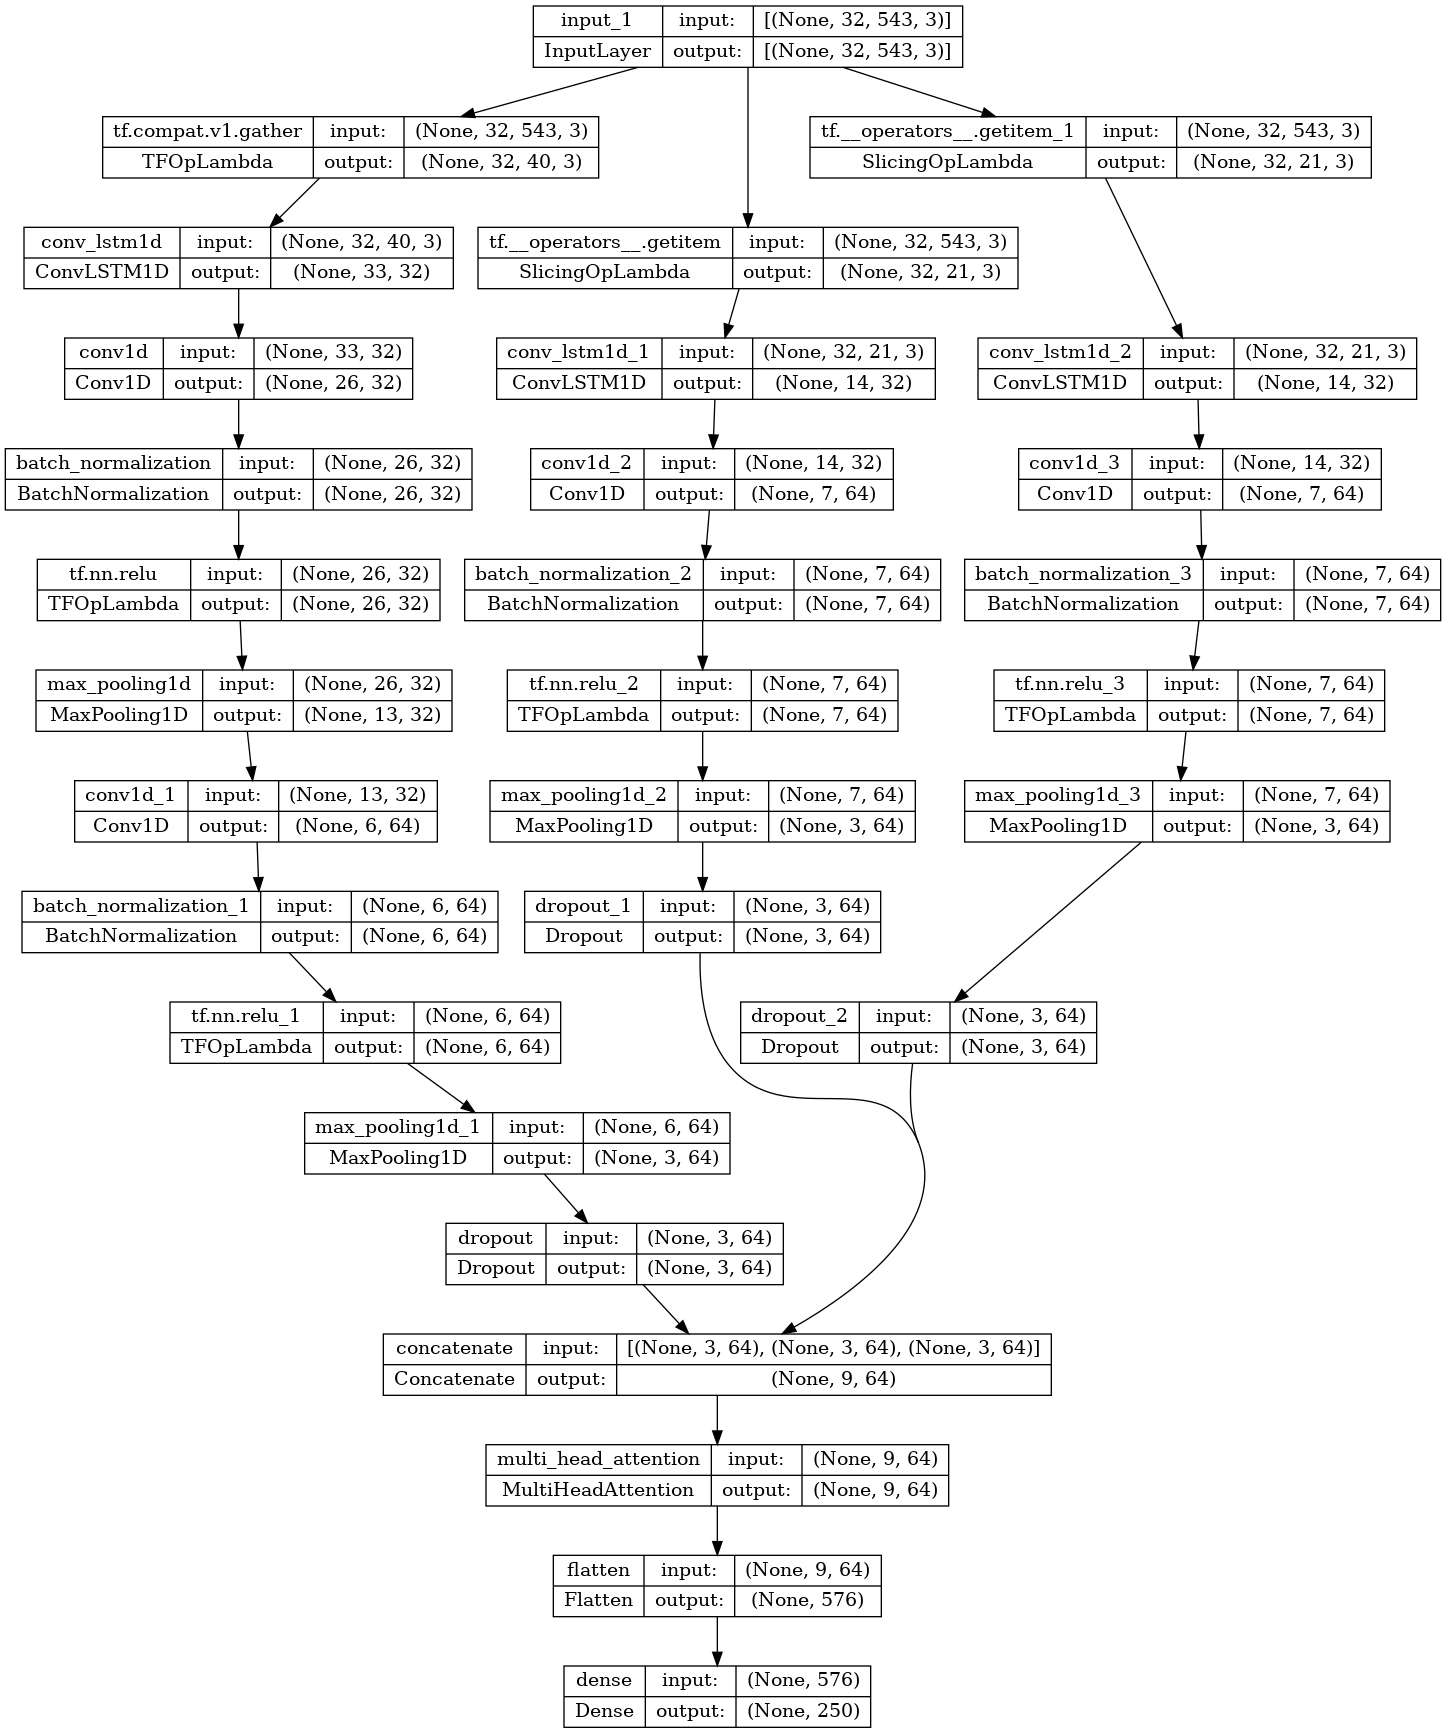

In [74]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [82]:
model(samples)

2023-03-11 15:31:22.091099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


<tf.Tensor: shape=(128, 250), dtype=float32, numpy=
array([[0.00400868, 0.00396742, 0.0039943 , ..., 0.00400184, 0.00399077,
        0.00399848],
       [0.0040079 , 0.00395535, 0.00398936, ..., 0.00400509, 0.00397843,
        0.00400143],
       [0.00401583, 0.0039346 , 0.00398564, ..., 0.00398445, 0.00397695,
        0.00399774],
       ...,
       [0.00400657, 0.00395443, 0.00398822, ..., 0.00400813, 0.00398444,
        0.0040043 ],
       [0.00400873, 0.00392509, 0.0039915 , ..., 0.00398371, 0.0039726 ,
        0.00400193],
       [0.00401105, 0.00394029, 0.00399187, ..., 0.00399376, 0.00395873,
        0.004001  ]], dtype=float32)>